# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does pretty well also, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

In [3]:
#
# Code to read in the MNIST data set
# Make sure you have the four gzipped files containing the data
#
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [4]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the test set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [5]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

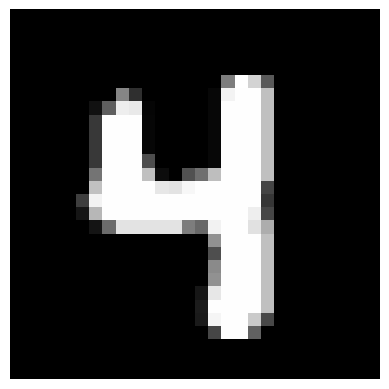

In [6]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [7]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [32]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d)) # mean for each class
    sigma = np.zeros((k,d,d)) # covariance of matrix
    pi = np.zeros(k) # frequency of label?
    c = 2700
    for i in range(k):
        temp = x[y==i]
        mu[i] = np.mean(temp, axis=0)
        sigma[i] = np.cov(temp, rowvar=False) + (c * np.eye(d))
        pi[i] += 1
    # for i in range(k):
    #     temp = x[y==1]
    #     mu[i] = np.mean()
    ###
    ### Your code goes here
    ###
    # Halt and return parameters
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

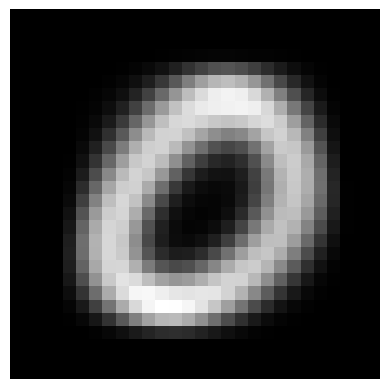

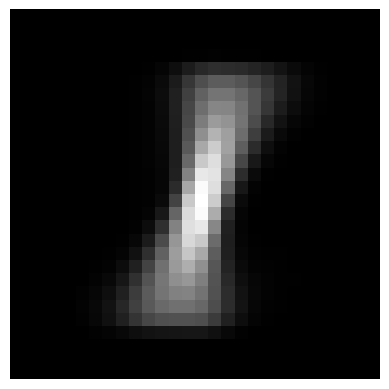

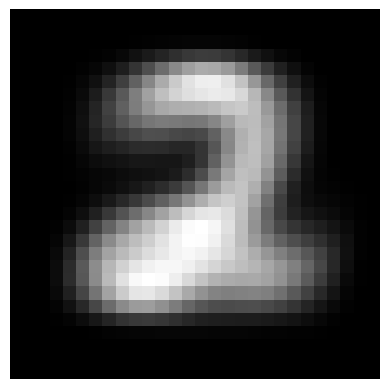

In [31]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

In [ ]:
def cFinder(train, trainLabel, test, testLabel):
    mu, sigma, pi = fit_generative_model(train, trainLabel)
    res = 0
    list = [2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100]
    lowError = float('inf')
    for c in list:
        #arr for distributions
        temp = []
        for i in range(10):
            # get sigma with cI and make smooth
            sigmac = sigma[i] + c * np.eye(sigma.shape[1])
            # multivar normal makes normal distritbuino using mu[i] (revise)
            temp.append(multivariate_normal(mean=mu[i], cov=sigmac))
        # log probabilities
        log_pi = np.log(pi)
        predictions = []
        for x in test:
            log_probs = [log_pi[i] + temp[i].logpdf(x) for i in range(10)]
            # argmax picks class with highest log probability (revise)
            predictions.append(np.argmax(log_probs))
        # get error, np.mean is basically getting total numbers of error and dividing it by len(testlabel)
        error = np.mean(np.array(predictions) != testLabel)
        # get min error
        if error < lowError:
            lowError = error
            res = c

    return res, lowError


bestc, error = cFinder(train_data,train_labels,test_data,test_labels)
print(bestc)
print(error)

2700
0.0428


## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [ ]:
#
# Compute log Pr(label|image) for each [test image,label] pair.
#
k = 10
c = 2700
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    # I didnt know I had to do regular her etoo
    regular = sigma[label] + c * np.eye(sigma[label].shape[0])
    rv = multivariate_normal(mean=mu[label], cov=regular)
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
#
# Finally, tally up score
#
errors = np.sum(predictions != test_labels)
print ("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 436 errors out of 10000


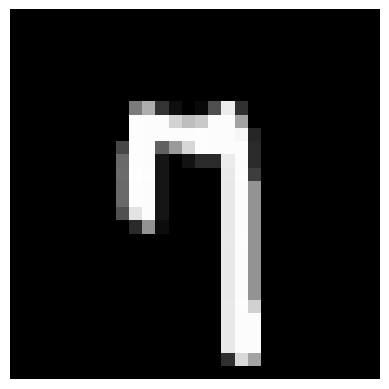

True Label: 7, Predicted Label: 9


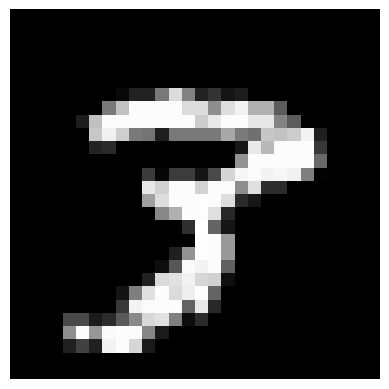

True Label: 3, Predicted Label: 9


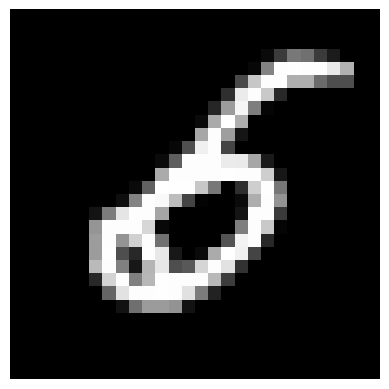

True Label: 5, Predicted Label: 6


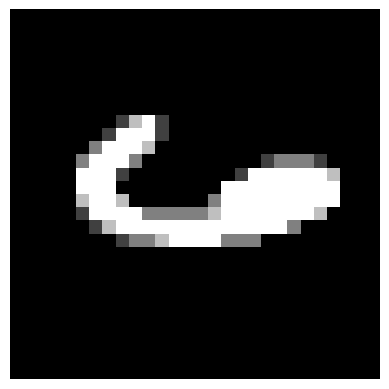

True Label: 6, Predicted Label: 4


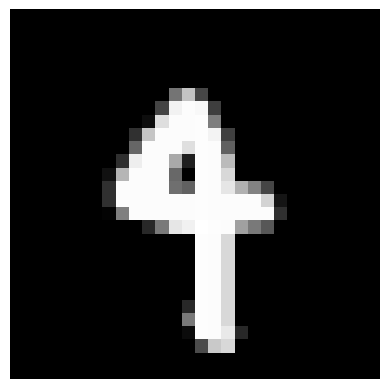

True Label: 4, Predicted Label: 9


In [ ]:
import random
wrong5 = np.where(predictions != test_labels)[0]

random5 = random.sample(list(wrong5), 5)

for index in random5:
    image = test_data[index]  
    right = test_labels[index]
    predicted = predictions[index]
    
    displaychar(image)  # Display the image
    print(f"True Label: {right}, Predicted Label: {predicted}")

## 4. Things to ponder

* What happens if you do not regularize the covariance matrices?
* What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?
* What value of c did you end up using? How many errors did your model make on the training set?
* We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

* If we do not regularize the covariance matrix, we might have bad generalization since we could overestimate the precision in area where there are little data
* If I set the value of c too high, the error rate becomes around 90%.  
Setting the value of c too high causes our covariance matrix to be regularized too much, making us lose data and having a worse model fit than before. I think it is because  
the model thinks that we have no corrolation between our values and think our variance is too large.
* I thought c values always had to be small, but I kept changing the range of the c values I am testing so that I am testing bigger values since it kepts choosing the largest number in my c values matrix  
finally, I found that 2700 was the best with a error rate of 4.28%
* Using a different regularization constant for each class can help the model adapt to different variances and covariances of each data. However, I think this might increase the time complexity and make run time super slow